# Description
This script can be used for an optimization with an cylinder as an initial geometry. The diameter from the cylinder is fixed.

In [1]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ddgclib._catenoid import *
from ddgclib._truncated_cone import *
from ddgclib._plotting import *

from timeit import default_timer as timer


def curvature(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    #curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan
    #N_f0 = normalized(N_f0)[0]
    #curvature_dict = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i

'''
            for v in HC.V:
                #TODO: REMOVE UNDER NORMAL CONDITIONS:
                if 0: # boolean operatore for =false
                    if v in bV:
                        continue
                N_f0 = np.array(
                    [0.0, 0.0, R * np.sin(theta_p)]) - v.x_a  # First approximation
                # for bridges this should be something like:
                # N_f0 = v.x_a - np.array([v.x_a[0], v.x_a[1], 0.0])
                N_f0 = normalized(N_f0)[0]
                N_i.append(N_f0)
                F, nn = vectorise_vnn(v)
                # Compute discrete curvatures
                c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0) # curvature_dict - calculating the curvature at the vertex v
'''


def b_disc_angle(v, r, bV, print_out=True):
    """
    Takes boundary vertex v and outputs the contact angle

    v: vertex
    N: normal vector estimating the direction of the surface (liquid to gas)
    """

    #N_i = []  # Temp cap rise normal

    # -------------
    angle_list = []
    #N_f0 = v.x_a - np.array([v.x_a[0], v.x_a[1], 0.0])
    N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan


    N_f0 = normalized(N_f0)[0]
    #N_i.append(N_f0)
    #print(f'N_f0 = {N_f0}')
    F, nn = vectorise_vnn(v)
   # c_outd = b_curvatures_hn_ij_c_ij_play(F, nn, n_i = N_f0)
    c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)
    vij = []


    for vn in v.nn:
        if vn in bV:
            continue
        else:
            vij.append(vn)

    if 0:
        for vn in v.nn:
            if vn in bV:
                vij.append(vn)


    E_ij = vij[0].x_a - v.x_a
    E_ik = vij[1].x_a - v.x_a
    E_ij_ik = np.cross(E_ij, E_ik)
    E_ij_ik_norm = np.linalg.norm(E_ij_ik) # || E_ij ^ E_ik ||
    dir_vec = E_ij_ik / E_ij_ik_norm

    if np.dot(N_f0, dir_vec) < 0:
        dir_vec = - dir_vec
    #dir_vec = N_f0
    '''
    Try and error
    '''
    #dir_vec = N_f0
   # c_outd = b_curvatures_hn_ij_c_ij_play(F, nn)
   # dir_vec = normalized(dir_vec)[0]
    # --------------------

    # Compute the curvature and the dual areas
    #F, nn = vectorise_vnn(v)
    #c_outd = b_curvatures_hn_ij_c_ij_play(F, nn)

    K_H_i = c_outd['K_H_i']


    #TODO: Adjust for other geometric approximations:
    #l_a = 2 * np.pi * r / len(bV)  # arc length
    Xi = 1
    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)
    # Approximate radius of the great shpere K = (1/R)**2:
    #r =  #TODO: test if this is a good approximation
    R_approx = 1 / np.sqrt(K_H_i)
    theta_p_approx = np.arccos(min([r / R_approx, 1]))
    h = R_approx - r * np.tan(theta_p_approx)
    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

    # A_approx  # Approximate area of the spherical cap
    kg_ds = 2 * np.pi * Xi - K_H_i * (A_approx)
    ds = 2 * np.pi * r  # Arc length of whole spherical cap
    k_g = kg_ds / ds  # / 2.0
    phi_est = np.arctan(R_approx * k_g)

    if print_out:
       # print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')
       # print(f'cos = {[r / R_approx]}')
        print(f'phi_est = {phi_est * 180 / np.pi}')
        print(f'E_ij = {E_ij}')
        print(f'E_ik = {E_ik}')
        print(f'E_ij_ik = {E_ij_ik}')
        print(f'dir_vec = {dir_vec}')
        print(f'np.dot(E_ij_ik_norm, dir_vec) = {np.dot(E_ij_ik_norm, dir_vec)}')
        print(f'E_ij_ik_norm = {E_ij_ik_norm}')
        print(f'vij = {vij}')

    return phi_est, dir_vec, E_ij, E_ik, E_ij_ik# , de # (sum of edge lengths)




def b_force(v, theta_p, print_out=True):
    """
    The force on the three-phase contact angle
    Theta_i: Estimated sector angle of vertex i
    theta_p: Equilibrium three-phase contact angle
    """


    phi_est, l_a = b_disc_angle(v)
    # Compute boundary forces
    # N m-1
    gamma_bt = gamma * (np.cos(phi_est)
                        - np.cos(theta_p)) * np.array([0, 0, 1.0])

    if print_out:
        print(f'phi_est  = {phi_est * 180 / np.pi}')
        #print(f'dK[i] = {dK[i]}')
    return gamma_bt


def b_move_vertex(v, Theta_i, theta_p, print_out=True):
    """
    Move the boundary vertex
    """

    F_bt = gamma_bt * l_a  # N
    new_vx = v.x + 1e-1 * F_bt
    new_vx = tuple(new_vx)
    HC.V.move(v, new_vx)
    bV_new.add(HC.V[new_vx])




In [2]:
'''
in this part of the code, the boundarys will be closed with the function close_boundary.

'''
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)

#    boundary_top.add(vat) # from stefan
#    boundary_bottom.add(vab) # from stefan

    boundary_top.append(vat)
    boundary_bottom.append(vab)
    return HC, boundary_top, boundary_bottom

In [3]:
'''
Function for calculating the volume of the mesh
'''
def volume(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    #print(curvature_dict)
    V_ijk = curvature_dict['V_ijk']
    N_i = curvature_dict['N_i']
    #print(N_i)
    return V_ijk


'''
V = 0
for v in HC.V:
    V_ijk = volume(v)
    #print(V_ijk)
    V += np.sum(V_ijk)

V = V/12
'''

'\nV = 0\nfor v in HC.V:\n    V_ijk = volume(v)\n    #print(V_ijk)\n    V += np.sum(V_ijk)\n\nV = V/12\n'

In [4]:
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t
    avg = sum_num / len(num)
    return avg

# Functions

In [5]:

def fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax, contact_angle = True):
    '''
    length = length of the inital cone
    tau = size of time step
    t_f = breaking condition in the while-loop = last time step
    d = diameter of the initial cyliner
    '''
    starttime = timer()
    print('Simulation is started!')
    print('-------------------------------------')

    r_l = d_l / 2
    r_u = d_u / 2

    v_l = 0
    v_u = length +v_l

    r_approx = length/2.0  # approximate radius of the contact angle spherical cap
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''

    HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement)

    # Define bottom boundary condition
    boundary_bottom = []
    N_f0_vectors_pairs = []
    for v in HC.V:
        #if v.x[2] == v_l:
        #if v.x[2] >= v_l - 1e-5 and v.x[2] <= v_l + 1e-5 or v.x[2] == v_l:
        if v.x[2] == v_l:
          #  print(f'v.x bottom ={v.x}')
            boundary_bottom.append(v)

            ################
            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
            N_f0_vectors_pairs.append([v.x_a, N_f0])
            ################

    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        #if v.x[2] == v_u:
        #if v.x[2] >= v_u - 1e-5 and v.x[2] <= v_u + 1e-5 or v.x[2] == v_u:
        if v.x[2] == v_u:
           # print(f'v.x top ={v.x}')
            boundary_top.append(v)

            ################
            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
            N_f0_vectors_pairs.append([v.x_a, N_f0])
            ################
    #print(N_f0_vectors_pairs)
   # HC, boundary_top, boundary_bottom = close_boundary(HC, boundary_top, boundary_bottom)
    '''
    ----------------------------------------------------
    Dummy parameter for the residual
    '''
    # runvariable for the iteration tracking
    residual_iteration = 0
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    volume_list = []
    contact_angle_list_bottom   = []
    contact_angle_list_top      = []

    '''
    ---------------------------------------------------------------------------------------------------------------------------
    From here, the optimization is started
    '''
    iters = 0
    while True:

        if itermax == 0:
            print('Mesh is generated. Optimization was not carried out because itermax = 0.')
            break

        if iters > itermax:
            endtime = timer()
            print('-------------------------------------')
            print("Too many iterations! Simulation is canceled!")
            print(f"Time elapsed for canceled Simulation: {endtime-starttime:.2f} s")

            break

        # Loop through all interior vertices
        # calculating the volume of the entire bridge
        '''
        New Part Starting 1  ------------------------
        '''
        V_current = 0
        number_v = 0

        for v in HC.V:
            number_v += 1

            V_ijk = volume(v)
            #print(V_ijk)
            V_current += np.sum(V_ijk)

        V_current = V_current/12

        volume_list.append(V_current)


        cHCV = copy.copy(HC.V)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        v_boundary_interior = {}
        '''
        Start boundary conditions ----------------------------------------------------------------------------------------------------------------- Start BC
        '''

        contact_angle_list_bottom_dummy = []
        contact_angle_list_top_dummy   = []
       # print(f'number of vertexes = {number_v}')
        for v in cHCV:
            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
            N_f0_vectors_pairs.append([v.x_a, N_f0])
            # exclude boundaries
            if v in set(boundary_bottom):
                #continue
                #Theta_i = 2 * np.pi / len(boundary_bottom)
               # print('.')
               # print(f'Boundary bottom:')
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_bottom, print_out=False)
                contact_angle_list_bottom_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)
               # print(f'phi_est radian = {phi_est}')
                # print(f'phi_est gradient = {phi_est * 180 / np.pi}')
                #gamma_bt

                for vnn in v.nn:
                    if (vnn in boundary_bottom): # or (vnn in boundary_top):
                        continue
                    else:
                        # vnn_factor = phi_est - theta_c early edition
                        #angle_diff_print = (phi_est - theta_c)
                        #angle_diff = np.cos(phi_est) - np.cos(theta_c)
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) *gamma * dE
                        vnn_factor = F_b * dir_vec
                        if 0:
                            print(f'dir_vec = {dir_vec}')
                            print(f'F_b = {F_b}')
                            print(f'vnn_factor = {vnn_factor}')
                            print(f'angle_diff = {angle_diff}')
                            print(f'angle_diff_print = {angle_diff_print * 180 / np.pi}')
                            print(f'vnn_factor = {vnn_factor}')

                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor

                continue

            # Define top boundary condition
            if v in set(boundary_top):

                #Theta_i = 2 * np.pi / len(boundary_top)
                #print('.')
                #print(f'Boundary top:')
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_top, print_out=False)

               # contact_angle_list_top_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)

                for vnn in v.nn:
                    #if (vnn in boundary_bottom) or (vnn in boundary_top):
                    if (vnn in boundary_top): # or (vnn in boundary_bottom)
                        continue
                    else:
                       # vnn_factor = phi_est - theta_c early edition
                        #vnn_factor = gamma * (np.cos(phi_est) - np.cos(theta_c)) * E_ij_ik / dE
                        contact_angle_list_top_dummy.append(phi_est)
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) * gamma * dE
                        vnn_factor = F_b * dir_vec
                        # vnn_factor = gamma * (phi_est - theta_c) * E_ij_ik / dE

                       # vnn_factor = theta_c - phi_est
                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            '''
            End boundary conditions ----------------------------------------------------------------------------------------------------------------- end BC
            '''
            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)

            # Enforce boundary contact angle
            db = np.zeros_like(HNdA_i)

           # print(f'v_boundary_interior = {v_boundary_interior}')
            if v.x in v_boundary_interior.keys():

                #db = 1e-1 * tau * v_boundary_interior[v.x] * HNdA_i#  normalized(HNdA_i)[0]
               # db =  tau * v_boundary_interior[v.x] * HNdA_i # normalized(HNdA_i)[0]
                db = v_boundary_interior[v.x]  # normalized(HNdA_i)[0]
                #print(f'normalized HNdA_i = {normalized(HNdA_i)}')
                #print(f'normalized HNdA_i[0] = {normalized(HNdA_i)[0]}')
               # print(f'vnn.x = {vnn.x}')
               # print(f'v_boundary_interior[vnn.x] = {v_boundary_interior[vnn.x]}')
              #  print(f'HNdAi = {HNdA_i}')
               # print(f'db = {db}')

            else:
                pass


            # Step in time
            df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            if 0:
                df[2] = 0
                db[2] = 0
            #df[1] = 0

            if iters < 75:
                # db = 0
                db = 0
            else:
                db = db

            if contact_angle: # condition if the contact angle is activated
                db = db
            else:
                db = 0

           # db = np.dot(db, N_f0)*N_f0
           # df = np.dot(df, N_f0)*N_f0



            #v_new = v.x_a - tau/2 * df  + tau/2 * db old
            v_new = v.x_a - tau/2 * df  + tau/2 * db
            #v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))
            df_list_dummy.append(np.linalg.norm(df+db))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))

        #contact_angle_list_bottom_dummy.append(phi_est) theta_p_approx * 180 / np.pi
        contact_angle_list_bottom.append(cal_average(contact_angle_list_bottom_dummy)* 180 / np.pi)
        contact_angle_list_top.append(cal_average(contact_angle_list_top_dummy)* 180 / np.pi)

        iters += 1
        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))
        # save the numbers of iteration for lately plotting
        iteration_list.append(iters)
        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        #print(iters)
        print(f'number of iteration ={iters}')
       # print(f'len_boundary_bottom = {len(boundary_bottom)}')
       # print(f'boundary_top = {len(boundary_top)}')


        if iters%100 == 0:
            # print(f"Time elapsed: {complex[6]-complex[5]:.2f} s")
            interimstime = timer()
            print(f"Iteration elapsed: {iters:.0f}")
            print(f"Time elapsed:{interimstime-starttime:.2f} s")
            print(f"Amount of highest displacement: {max(df_list_dummy)*10**6:.2f} mikrometer")


        if max(df_list_dummy) < breaking_condition:
            endtime = timer()
            print('-------------------------------------')
            print("Simulation is finished and is terminated without a problem.")
            print(f"Time elapsed for hole Simulation: {endtime-starttime:.2f} s")
            break



    return (HC, iteration_list, df_list_min, df_list_max, volume_list,contact_angle_list_bottom, contact_angle_list_top, N_f0_vectors_pairs,dHNdA_list_min, dHNdA_list_max, dHNdA_list_dummy)





In [7]:
#gamma = 728e-6  # N/m, surface tension of water at 20 deg C
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
refinement= 3 # NOTE: 2 is the minimum refinement needed for the complex to be manifold
'''
d_l = 0.8e-3 # radian on the lower side of the cone
d_l = 1.6e-3 # radian on the lower side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 1.6e-3 # diameter on the upper side of the cone
d_u = 0.36 * 3e-3
d_l = d_u
length = 0.7e-3 # length of the cone
length = 0.294 * 3e-3
'''



tau = 0.1    # Endtime for calculation
tau = 0.5    # Endtime for calculation
itermax = 1

'''
from Liam 19939
'''
r_i = 1e-3 # Particle Radian

angle = 10 # angle in degree
S = 0.1 # dimensionless seperation distance

y_i = np.sin(angle * np.pi/180.0) * r_i # calculated radian of the liquid bridge
d_l = 2 * y_i
d_u = d_l
length = S * r_i



# TEST angle:
theta_p = 20 * np.pi/180.0  # Three phase contact angle

'''
t_f = 100 # final time of the time step
V_final = 0.084
damping_factor = 1
'''


breaking_condition = 1e-9

#dummy_parameter = fun_liquid_bridge(-0.5, 0.5,0, 0,1) # v_l, v_u, tau, tf, d
# def fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, volume_constraint)
#fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax):
# def fun_liquid_bridge_test(d_l, d_u, length, refinement, tau, gamma, breaking_condition,itermax):
dummy_parameter2 = fun_liquid_bridge_N(d_l, d_u, length, refinement, theta_p,tau, gamma, breaking_condition,itermax,contact_angle = True)

# dummy_parameter = fun_liquid_bridge(d_l, d_u, length, refinement, tau, t_f, gamma, V_final, damping_factor, True)

HC = dummy_parameter2[0]
iteration_list = dummy_parameter2[1]
df_list_min = dummy_parameter2[2]
df_list_max = dummy_parameter2[3]
volume_list = dummy_parameter2[4]
contact_angle_list_bottom = dummy_parameter2[5]
contact_angle_list_top = dummy_parameter2[6]
N_f0_vectors_pairs = dummy_parameter2[7]
dHNdA_list_min = dummy_parameter2[8]
dHNdA_list_max = dummy_parameter2[9]
dHNdA_list_dummy = dummy_parameter2[10]




Simulation is started!
-------------------------------------
number of iteration =1
number of iteration =2
-------------------------------------
Too many iterations! Simulation is canceled!
Time elapsed for canceled Simulation: 0.83 s


In [1]:
plot_polyscope(HC)

NameError: name 'plot_polyscope' is not defined

(0.0, 1.0)

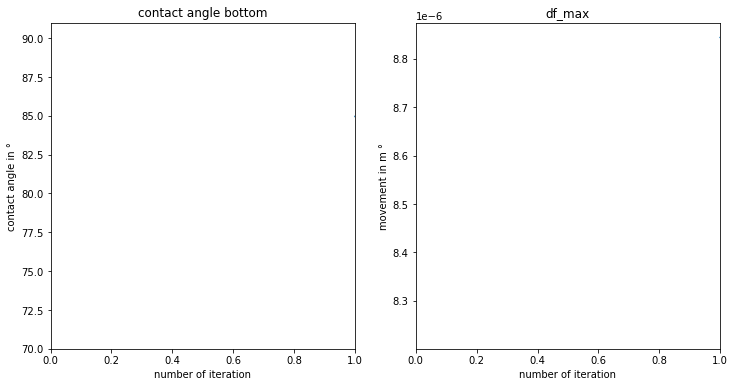

In [8]:
'''
Plot of the residual data
'''

fig_name = "contact_angle_notactivated10_20240219.png"
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))


ax[0].plot(iteration_list, contact_angle_list_top)
ax[0].hlines(20,-10,2300, colors = 'red', linestyle = '--')

#ax[0].set_yscale('log')

#ax[1].plot(iteration_list, contact_angle_list_top)
ax[1].plot(iteration_list, df_list_max)
#ax[1].plot(iteration_list, dHNdA_list_min)

#hlines(y, xmin, xmax, colors=None, linestyles='solid'

ax[0].set_title('contact angle bottom')
ax[1].set_title('df_max')

ax[0].set_xlabel("number of iteration")
ax[0].set_ylabel("contact angle in °")

ax[1].set_xlabel("number of iteration")
ax[1].set_ylabel("movement in m °")

ax[0].set_ylim(70, 91)
ax[0].set_xlim(0, itermax)

#ax[1].set_ylim(0, 91)
ax[1].set_xlim(0, itermax)



#fig.savefig(fig_name)

In [9]:
print(f'contact angle = {contact_angle_list_top[-1]}')
print(f'volume = {volume_list[-1]*10e11}')
print(f'df_max = {df_list_max[-1]}')

contact angle = 85.38184748208623
volume = 1.5938588737711756
df_max = 8.231500455781276e-06


In [10]:
dHNdA_list_max[-1]

0.00011307006120578675

In [11]:
if 0:
    from ddgclib._truncated_cone import *
    from ddgclib._plotting import *

    HC = Complex(3)
    HC.load_complex('test_vom_20240209.json')

    plot_polyscope(HC)

In [12]:
def save_complex(HC,filename):
    for v in HC.V:
       # print('---')
        v_new = []
        for i, vi in enumerate(v.x):
            #print(type(vi))
            v_new.append(float(vi))
            #v.x[i] = float(vi)
        HC.V.move(v, tuple(v_new))
        v.x_a = np.array(v.x_a, dtype='float')
        #v.x_a = v.x_a.astype(float)
        #for vi in v.x:
         #   print(type(vi))
    #print(type(v.x_a))
    HC.save_complex(fn = filename)

#save_complex(HC, 'test_vom_20240209_refinement4.json')

In [14]:
'''
Plotting of the normvecs (NF_0)
'''
def plot_polyscope_plus_normvec(HC, normveccts):
    # Initialize polyscope
    ps.init()
    ps.set_up_dir("z_up")

    do = coldict['db']
    lo = coldict['lb']
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)
    ### Register a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("my points", my_points)
    ps_cloud.set_color(tuple(do))
    #ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    faces = triangles
    ### Register a mesh
    # `verts` is a Nx3 numpy array of vertex positions
    # `faces` is a Fx3 array of indices, or a nested list
    surface = ps.register_surface_mesh("my mesh", verts, faces,
                             color=do,
                             edge_width=1.0,
                             edge_color=(0.0, 0.0, 0.0),
                             smooth_shade=False)

    # Add a scalar function and a vector function defined on the mesh
    # vertex_scalar is a length V numpy array of values
    # face_vectors is an Fx3 array of vectors per face
    if 0:
        ps.get_surface_mesh("my mesh").add_scalar_quantity("my_scalar",
                vertex_scalar, defined_on='vertices', cmap='blues')
        ps.get_surface_mesh("my mesh").add_vector_quantity("my_vector",
                face_vectors, defined_on='faces', color=(0.2, 0.5, 0.5))

    # View the point cloud and mesh we just registered in the 3D UI
    #ps.show()

    # Add normal vectors
    vecs_vert = []
    for v in verts:
        N_f0 = v - np.array([0.0, 0.0, v[2]])
        N_f0 = normalized(N_f0)[0]
        #N_f0_vectors_pairs.append([v.x_a, N_f0])
        vecs_vert.append(N_f0)
    vecs_vert = np.array(vecs_vert) * 1e-4
    #surface.add_vector_quantity("N_f0 vectors", vecs_vert, radius=0.001,
    #                            length=0.005, color=(0.2, 0.5, 0.5))
    surface.add_vector_quantity("N_f0 vectors", vecs_vert, vectortype='ambient')
    if 0:
        vertices = []
        for nv in normveccts:
            vertices.append(nv[0])
            vecs_vert.append(nv[1])

        vertices
        # visualize some random vectors per vertex
        ps_mesh.add_vector_quantity("rand vecs", vecs_vert, enabled=True)

        # set radius/length/color of the vectors
        ps_mesh.add_vector_quantity("rand vecs opt", vecs_vert, radius=0.001,
                                    length=0.005, color=(0.2, 0.5, 0.5))

    ps.show()

plot_polyscope_plus_normvec(HC, N_f0_vectors_pairs)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [15]:
'''
Plotting of the normvecs (dir_vecs)
'''
def plot_polyscope_plus_normvec(HC, normveccts):
    # Initialize polyscope
    ps.init()
    ps.set_up_dir("z_up")

    do = coldict['db']
    lo = coldict['lb']
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)
    ### Register a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("my points", my_points)
    ps_cloud.set_color(tuple(do))
    #ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    faces = triangles
    ### Register a mesh
    # `verts` is a Nx3 numpy array of vertex positions
    # `faces` is a Fx3 array of indices, or a nested list
    surface = ps.register_surface_mesh("my mesh", verts, faces,
                             color=do,
                             edge_width=1.0,
                             edge_color=(0.0, 0.0, 0.0),
                             smooth_shade=False)


    # Add normal vectors
    vecs_vert = []
    for v in verts:
        N_f0 = v - np.array([0.0, 0.0, v[2]])
        N_f0 = normalized(N_f0)[0]

        #'''
        F, nn = vectorise_vnn(v)
        c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)
        vij = []


        for vn in v.nn:
            if vn in bV:
                continue
            else:
                vij.append(vn)




        if 0:
            for vn in v.nn:
                if vn in bV:
                    vij.append(vn)




        E_ij = vij[0].x_a - v.x_a
        E_ik = vij[1].x_a - v.x_a
        E_ij_ik = np.cross(E_ij, E_ik)
        E_ij_ik_norm = np.linalg.norm(E_ij_ik) # || E_ij ^ E_ik ||
        dir_vec = E_ij_ik / E_ij_ik_norm

        if np.dot(N_f0, dir_vec) < 0:
            dir_vec = - dir_vec
        #'''
        #N_f0_vectors_pairs.append([v.x_a, dir_vec])
        #vecs_vert.append(N_f0)
        vecs_vert.append(dir_vec)
    vecs_vert = np.array(vecs_vert) * 1e-4
    #surface.add_vector_quantity("N_f0 vectors", vecs_vert, radius=0.001,
    #                            length=0.005, color=(0.2, 0.5, 0.5))
    surface.add_vector_quantity("N_f0 vectors", vecs_vert, vectortype='ambient')


    ps.show()

plot_polyscope_plus_normvec(HC, N_f0_vectors_pairs)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

AttributeError: 'numpy.ndarray' object has no attribute 'x_a'

In [92]:
 '''
Check without the contact-angle, what I'm doing here...
'''

# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ddgclib._particle_liquid_bridge_initial_truncated_cone_flo import *
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt

#set parameters for plots
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.it"] = "Arial:italic"
plt.rcParams["mathtext.rm"] = "Arial"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

# refinement=3# NOTE: 2 is the minimum refinement needed for the complex to be manifold


#gamma = 0.0728  # N/m, surface tension of water at 20 deg C

gamma = 0.078  # N/mm, surface tension of water at 20 deg C
refinement = 3

diameter_l = 1.6e-3  # diameter on the lower side of the cone in m
diameter_u = 1.6e-3  # diameter on the upper side of the cone in m

length = 0.7e-3  # length of the initial cylinder
length = 0.4e-3  # length of the initial cylinder

t_f = 0  # End-Residual-Time // if t_f = 0, no optimization
tau = 0.05  # step-size


complex = fun_liquid_bridge_truncated_cone_N(diameter_l, diameter_u, length, refinement, tau, t_f, gamma)

# return(HC, iteration_list, df_list_min, df_list_max,res_list, starttime, endtime)

HC_1 = complex[0]
iteration_list = complex[1]
df_list_min = complex[2]
df_list_max = complex[3]
res_list = complex[4]

print(f"Time elapsed: {complex[6] - complex[5]:.2f} s")

plot_polyscope(HC_1)

Time elapsed: 0.22 s
np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 

# Using the Function

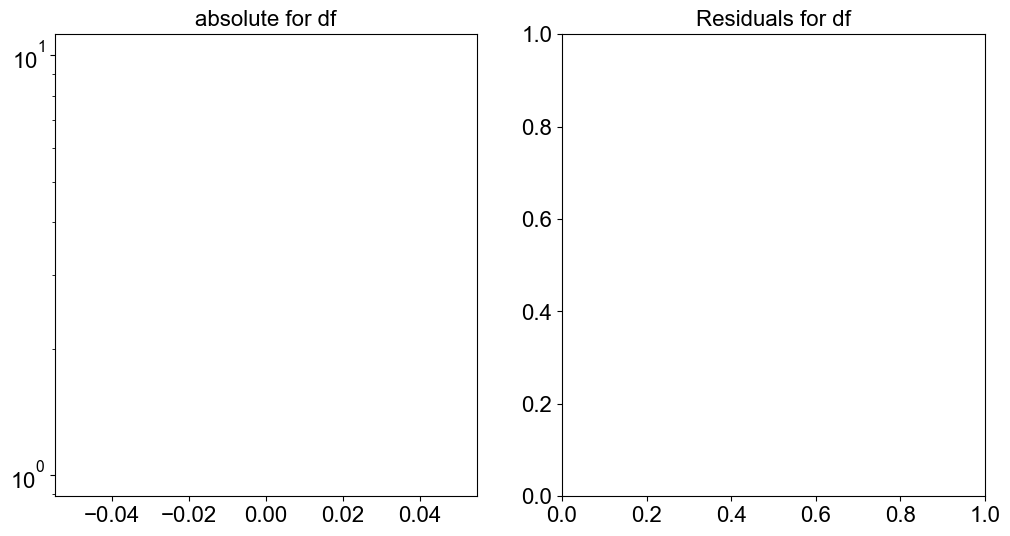

In [93]:
'''
Plot of the residual data
'''
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 6))


ax[0].plot(iteration_list, df_list_max)
ax[0].plot(iteration_list, df_list_min)
ax[0].set_yscale('log')

#ax[1].plot(iteration_list, res_list)
#ax[1].plot(iteration_list, dHNdA_list_min)



ax[0].set_title('absolute for df')
ax[1].set_title('Residuals for df')

fig.savefig('Residuals_with_volume.png')

In [94]:
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [95]:
'''
Old version


def b_disc_angle(v, r, print_out=True):
    """
    Takes boundary vertex v and outputs the contact angle

    v: vertex
    N: normal vector estimating the direction of the surface (liquid to gas)
    """

    # Compute the curvature and the dual areas
    F, nn = vectorise_vnn(v)
    c_outd = b_curvatures_hn_ij_c_ij_play(F, nn)

    K_H_i = c_outd['K_H_i']


    #TODO: Adjust for other geometric approximations:
    #l_a = 2 * np.pi * r / len(bV)  # arc length
    Xi = 1
    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)
    # Approximate radius of the great shpere K = (1/R)**2:
    #r =  #TODO: test if this is a good approximation
    R_approx = 1 / np.sqrt(K_H_i)
    theta_p_approx = np.arccos(np.min([r / R_approx, 1]))
    h = R_approx - r * np.tan(theta_p_approx)
    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

    # A_approx  # Approximate area of the spherical cap
    kg_ds = 2 * np.pi * Xi - K_H_i * (A_approx)
    ds = 2 * np.pi * r  # Arc length of whole spherical cap
    k_g = kg_ds / ds  # / 2.0
    phi_est = np.arctan(R_approx * k_g)

    if print_out:
        print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')

    return phi_est
'''

'\nOld version\n\n\ndef b_disc_angle(v, r, print_out=True):\n    """\n    Takes boundary vertex v and outputs the contact angle\n\n    v: vertex\n    N: normal vector estimating the direction of the surface (liquid to gas)\n    """\n\n    # Compute the curvature and the dual areas\n    F, nn = vectorise_vnn(v)\n    c_outd = b_curvatures_hn_ij_c_ij_play(F, nn)\n\n    K_H_i = c_outd[\'K_H_i\']\n\n\n    #TODO: Adjust for other geometric approximations:\n    #l_a = 2 * np.pi * r / len(bV)  # arc length\n    Xi = 1\n    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi\n    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)\n    # Approximate radius of the great shpere K = (1/R)**2:\n    #r =  #TODO: test if this is a good approximation\n    R_approx = 1 / np.sqrt(K_H_i)\n    theta_p_approx = np.arccos(np.min([r / R_approx, 1]))\n    h = R_approx - r * np.tan(theta_p_approx)\n    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap\n\n    # A_approx  